<a href="https://colab.research.google.com/github/ansh-mehta/EngiNx-2019/blob/master/heart_enginx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Choose the file from explorer**

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
from google.colab import files
uploaded = files.upload()

import io
heart_df = pd.read_csv(io.BytesIO(uploaded['heart_enginx.csv']))
heart_df = heart_df.dropna()
heart_df = heart_df.replace('-9',pd.np.nan).dropna()
heart_df = heart_df.replace('?',pd.np.nan).dropna()
heart_df


heart_df["age"]= heart_df["age"].astype(float)
heart_df["sex"]=(heart_df["sex"]).astype(float)
heart_df["cp"]=(heart_df["cp"]).astype(float)
heart_df["rest_bp"]=(heart_df["rest_bp"]).astype(float)
heart_df["chol"]=(heart_df["chol"]).astype(float)
heart_df["fast_bs"]=(heart_df["fast_bs"]).astype(float)
heart_df["rest_ecg"]=(heart_df["rest_ecg"]).astype(float)
heart_df["max_hb"]=(heart_df["max_hb"]).astype(float)
heart_df["ex_angina"]=(heart_df["ex_angina"]).astype(float)
heart_df["old_peak"]=(heart_df["old_peak"]).astype(float)
heart_df["slope"]=(heart_df["slope"]).astype(float)
heart_df["ca"]=(heart_df["ca"]).astype(float)
heart_df["thal"]=(heart_df["thal"]).astype(float)
heart_df["num"]=(heart_df["num"]).astype(int)
print(list(heart_df.columns))
print(list(heart_df.dtypes))


Saving heart_enginx.csv to heart_enginx.csv


# **Randomize data**

In [0]:
heart_df = heart_df.reindex(np.random.permutation(heart_df.index))

# **Choose features, lables and split data**

In [10]:
def preprocess_features(heart_df):
    selected_features = heart_df[['age','sex','cp','rest_bp','chol','fast_bs','rest_ecg','max_hb','ex_angina','old_peak','slope','ca','thal']]
    processed_features = selected_features.copy()
    return processed_features

def preprocess_targets(heart_df):
    output_target = pd.DataFrame()
    output_target["num"]=heart_df["num"]
    return output_target

training_examples = preprocess_features(heart_df.head(200))
training_targets = preprocess_targets(heart_df.head(200))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(heart_df.tail(98))
validation_targets = preprocess_targets(heart_df.tail(98))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,age,sex,cp,rest_bp,chol,fast_bs,rest_ecg,max_hb,ex_angina,old_peak,slope,ca,thal
count,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
mean,51.2,0.7,3.1,133.0,238.0,0.0,0.6,144.1,0.3,0.8,-1.6,-3.7,-0.8
std,9.2,0.5,1.0,18.2,70.7,1.0,0.9,24.8,0.5,1.0,4.9,4.9,6.9
min,29.0,0.0,1.0,92.0,-9.0,-9.0,0.0,71.0,0.0,0.0,-9.0,-9.0,-9.0
25%,44.0,0.0,2.0,120.0,203.8,0.0,0.0,125.0,0.0,0.0,-9.0,-9.0,-9.0
50%,52.0,1.0,3.0,130.0,238.5,0.0,0.0,148.0,0.0,0.2,1.0,0.0,3.0
75%,57.0,1.0,4.0,140.5,285.2,0.0,2.0,162.2,1.0,1.5,2.0,0.0,6.0
max,74.0,1.0,4.0,200.0,518.0,1.0,2.0,202.0,1.0,4.2,3.0,9.0,7.0


Validation examples summary:


,age,sex,cp,rest_bp,chol,fast_bs,rest_ecg,max_hb,ex_angina,old_peak,slope,ca,thal
count,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0
mean,51.5,0.6,3.1,132.7,239.5,0.1,0.6,146.5,0.3,0.8,-1.5,-3.7,-1.0
std,9.5,0.5,1.0,19.1,62.9,0.3,0.9,23.1,0.4,1.1,4.9,5.0,7.1
min,31.0,0.0,1.0,100.0,-9.0,0.0,0.0,92.0,0.0,0.0,-9.0,-9.0,-9.0
25%,43.2,0.0,2.0,120.0,204.0,0.0,0.0,132.2,0.0,0.0,-9.0,-9.0,-9.0
50%,52.0,1.0,3.0,130.0,234.0,0.0,0.0,150.0,0.0,0.0,1.0,0.0,3.0
75%,58.0,1.0,4.0,140.0,273.5,0.0,2.0,162.8,1.0,1.2,2.0,0.0,6.0
max,71.0,1.0,4.0,200.0,394.0,1.0,2.0,194.0,1.0,6.2,3.0,3.0,7.0


Training targets summary:


,num
count,200.0
mean,0.9
std,1.3
min,0.0
25%,0.0
50%,0.0
75%,2.0
max,4.0


Validation targets summary:


,num
count,98.0
mean,0.8
std,1.2
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,4.0


# **Feature column and input function**

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):

    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(100)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

#**Create NNClassifier Model**

In [0]:
def train_nn_classifier_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
 
  periods = 10
  steps_per_period = steps / periods
  
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  dnn_classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      n_classes = 5,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["num"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["num"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["num"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  training_input_fn
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    
    dnn_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.    
    training_probabilities = dnn_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = dnn_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return dnn_classifier

#**Tune Hyper-parameters**

Training model...
LogLoss (on training data):
  period 00 : 1.41
  period 01 : 1.28
  period 02 : 1.20
  period 03 : 1.19
  period 04 : 1.19
  period 05 : 1.18
  period 06 : 1.18
  period 07 : 1.20
  period 08 : 1.20
  period 09 : 1.18
Model training finished.
accuracy 0.6122449
average_loss 1.1649598
loss 1.1649598
global_step 200


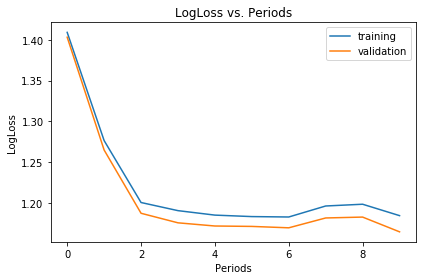

In [22]:
dnn_classifier = train_nn_classifier_model(
    learning_rate=0.018,
    steps=200,
    batch_size=1,
    hidden_units=[9,7],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
  )
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["num"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

evaluation_metrics = dnn_classifier.evaluate(input_fn=predict_validation_input_fn)

for i in list(evaluation_metrics):
  print(i,evaluation_metrics[i])